# Systèmes de reconnaissance de la parole avec librairies librosa
-----------------------------------------------------------------

# Aperçu

Ce projet est divisé en deux sections, la partie 1 et la partie 2. La première section met en œuvre un système élémentaire de reconnaissance de mots individuels en anglais. Le dispositif s'appuie sur une caractérisation du signal vocal par le biais des coefficients LPC (Codage Prédictif Linéaire) et une identification reposant sur l'algorithme des voisins les plus proches (k-NN), en se basant sur la distance élastique (Dynamic Time Warping - DTW). Le but de la seconde phase du projet est d'élaborer un système de reconnaissance vocale en exploitant les coefficients MFCC (Mel-Frequency Cepstral Coefficients) pour paramétriser le signal audio, et les Modèles de Markov Cachés (HMM) pour la catégorisation. 


## Installation des librairies et Lecture d'un fichier audio 
-----------------------------------------------------------------------

Nous commencerons par installer les librairies nécessaires.

In [1]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


Nous allons lire notre dataset audio: 

In [1]:
import librosa
audio, Fe = librosa.load('digit_dataset/0/0_jackson_0.wav')
print(audio, Fe)

[-0.01060764 -0.01393969 -0.01355745 ...  0.00738658  0.00377755
  0.        ] 22050


Dans ce cas:
- Audio : Vecteur Numpy contenant les valeurs des échantillons audio 
- Fe : est la fréquence d’échantillonnage.

- Voici l'audio que nous utilisons: 

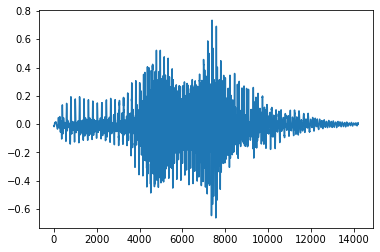

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# visualiser audio est un vecteur numpy contenant les valeurs des échantillons audio et Fe est la fréquence d’échantillonnage.
plt.plot(audio)

Voici un autre exemple de code permettant de parcourir une arborescence afin d’accéder aux 
fichiers audio (.wav) :

In [3]:
import os
list_of_s = []
input_folder='./digit_dataset' 
for dirname in os.listdir(input_folder):
    subfolder = os.path.join(input_folder, dirname)
    if not os.path.isdir(subfolder): 
        continue
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:
        filepath = os.path.join(subfolder, filename)
        list_of_s.append(filepath)

## Partie 1 : Système de reconnaissance de la parole basé sur les coefficients LPC et la classification des k plus proches voisins utilisant la distance élastique
------------------------------------------------------------------------------------

### 1.1 Paramétrisation des données audio à partir des coefficients LPC

- Calculer leur matrice des coefficients LPC

La méthode de Yule-Walker pour le calcul des coefficients LPC suit ces étapes :

Autocorrélation : Calculez l'autocorrélation du signal audio, qui est la corrélation du signal avec lui-même à différents décalages.

Formez une matrice R symétrique à partir des valeurs d'autocorrélation. La symétrie vient de la nature stationnaire du signal sur la trame, impliquant que R(i)=R(−i).

Résolution de l'équation : Utilisez l'équation de Yule-Walker, qui relie les autocorrélations aux coefficients LPC. La résolution se fait typiquement par l'équation récursive:

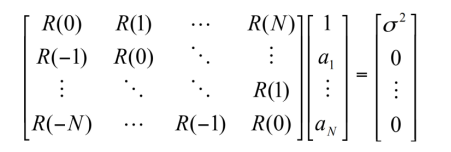

Coefficients LPC : Les solutions de l'équation de Yule-Walker sont les coefficients LPC. Ils vont etre utilisés pour prédire les échantillons de signal audio basés sur une combinaison linéaire des échantillons précédents.

Pour simplifier, sigma  la puissance de l'erreur de prédiction est égale à 1 dans notre cas.

In [43]:
import numpy as np
from scipy.linalg import solve_toeplitz

def calculate_lpc_coefficients(signal, order):
    """
    Calcule les coefficients LPC en utilisant l'équation Yule-Walker method.
    
    :param audio: The audio signal as a numpy array.
    :param order: The order of the LPC.
    :return: The LPC coefficients.
    """
    # Normalisation du signal
    # signal = signal / np.max(np.abs(signal))
    # Calcul de l'autocorrélation du signal
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:len(autocorr)//2+order+1]
    # Création de la matrice pour les autocorrélations
    R = autocorr[:order]
    # Résolution de l'équation de Yule-Walker pour sigma^2 = 1
    lpc_coeffs = solve_toeplitz((R, R), autocorr[1:order+1])
    return lpc_coeffs

# Chargement de l'audio et calcul des coefficients LPC
audio, Fe = librosa.load('digit_dataset/0/0_jackson_0.wav')
order = 12  # Ordre du modèle LPC
lpc_coeffs = calculate_lpc_coefficients(audio, order)
print("LPC Coefficients:", lpc_coeffs)

LPC Coefficients: [ 4.15060994 -6.77304368  4.01630426  2.77309812 -6.2580654   4.49914301
 -3.53358626  6.23181894 -8.04802336  5.82373752 -2.24638692  0.36074579]


La fonction ci-dessus permet de calculer les coefficient LPC en se basant sur l'équation de Yule-Walker: 

-- Normalisation : Elle normalise le signal pour que son amplitude maximale soit de 1. Cela permet de rendre les calculs des coefficients indépendants de l'amplitude du signal d'entrée.

-- Autocorrélation : Elle calcule l'autocorrélation du signal audio normalisé pour obtenir une séquence de valeurs représentant la corrélation du signal avec lui-même à différents décalages.

-- Matrice R : Elle forme une matrice à partir des valeurs d'autocorrélation. Cette matrice est symétrique et encode les relations linéaires entre les échantillons du signal.

-- Résolution de Yule-Walker : Avec sigma^2 = 1, elle résout l'équation de Yule-Walker pour obtenir les coefficients LPC, en utilisant la fonction solve_toeplitz qui est optimisée pour les matrices de Toeplitz.

### 1.2  Calculer et afficher la matrice des distances entre les signaux audio

### 1-2-1 Spliting dataset to training-test 

In [5]:
import os
import random
    
audio_files = []
labels = []
audio_directory = "digit_dataset/"
# Parcourir les dossiers de chiffres et collecter les noms de fichiers
for i in range(10):
        digit_folder = audio_directory + str(i)
        print(digit_folder)
        if os.path.exists(digit_folder):
            for filename in os.listdir(digit_folder):
                if filename.endswith('.wav'):
                    audio, _ = librosa.load(os.path.join(digit_folder, filename)) 
                    audio_files.append(audio)
                    labels.append(i)
print("Reading and storing audio and labels complete !")
# Mélanger les données tout en conservant la correspondance entre audio_files et labels
combined = list(zip(audio_files, labels))
random.shuffle(combined)
audio_files[:], labels[:] = zip(*combined)
# Séparer les données de test
test_size=0.2 # 20% pour test
split_index = int(len(audio_files) * (1 - test_size))
training_files = audio_files[:split_index]
training_labels = labels[:split_index]
test_files = audio_files[split_index:]
test_indices = list(range(split_index, len(audio_files)))

digit_dataset/0
digit_dataset/1
digit_dataset/2
digit_dataset/3
digit_dataset/4
digit_dataset/5
digit_dataset/6
digit_dataset/7
digit_dataset/8
digit_dataset/9
Reading and storing audio and labels complete !


In [6]:
print("Nombre de fichiers d'entraînement :", len(training_files))
print("Nombre d'Étiquettes d'entraînement :", len(training_labels))
print("Nombre de fichiers de test :", len(test_files))
print("Nombre d'indices de test :", len(test_indices))
print("Taille de chaque audio dans notre jeu de donnée : ", len(training_files[0]))

Nombre de fichiers d'entraînement : 1595
Nombre d'Étiquettes d'entraînement : 1595
Nombre de fichiers de test : 399
Nombre d'indices de test : 399
Taille de chaque audio dans notre jeu de donnée :  11935


### 1-2-2 Prametrisation par coeeficient LPC 

Aprés, nous allons paramétriser nos audio, en utilisant la fonction défini en dessus (paramétrisation par coeeficient LPC)

In [55]:
# Convertir les fichiers audio en séquences LPC
training_lpc = [calculate_lpc_coefficients(file, 3) for file in training_files]
test_lpc = [calculate_lpc_coefficients(file, 3) for file in test_files]

In [56]:
print("Nombre de fichiers d'entraînement :", len(training_lpc))
print("taille du vecteur LPC :", len(training_lpc[0])) 

Nombre de fichiers d'entraînement : 1595
taille du vecteur LPC : 3


### Calcul de la matrice de distance en utilisant la matrice de distance élastique

La distance élastique est calculée en utilisant l'equation vue 
relation de récurrence qui permet de trouver le chemin optimal alignant deux séquences de données temporelles. La fonction g(i, j) représente le coût cumulé pour aligner les points jusqu'aux positions i et j dans les deux séquences. Les pondérations ω v, ω d et ω h permettent d'ajuster le coût en fonction de l'orientation du chemin (verticale, diagonale, horizontale). La distance DTW totale entre deux séquences est le coût g à la fin des deux séquences, c'est-à-dire g(I, J). Le chemin optimal peut être retracé à partir de ce point jusqu'au début des séquences (1,1).

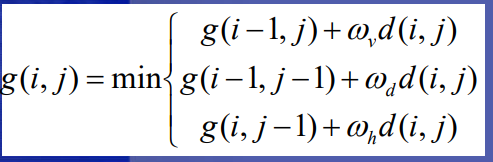

Nous allons implémenter dabord la fonction de distance élastique que nous utiliserons dans la fonction de KNN.

In [57]:
import numpy as np

def distance_elastique(sequence1, sequence2, omega_v=1, omega_d=1, omega_h=1):
    len_s1, len_s2 = len(sequence1), len(sequence2)
    dtw_matrix = np.full((len_s1 + 1, len_s2 + 1), np.inf)
    # Coût initial
    dtw_matrix[0, 0] = 0
    # Remplissage de la matrice
    for i in range(1, len_s1 + 1):
        for j in range(1, len_s2 + 1):
            cost = abs(sequence1[i - 1] - sequence2[j - 1])
            vertical = dtw_matrix[i - 1, j] + omega_v * cost
            diagonal = dtw_matrix[i - 1, j - 1] + omega_d * cost
            horizontal = dtw_matrix[i, j - 1] + omega_h * cost
            dtw_matrix[i, j] = min(vertical, diagonal, horizontal)
    
    return dtw_matrix[len_s1, len_s2]
# Exemple d'utilisation
seq1 = training_lpc[0]
seq2 = training_lpc[1]
dist = distance = distance_elastique(seq1, seq2)
print(dist)

0.18184593567843987


Nous allons utiliser cette fonction pour calculer la matrice de distance qui sera utiliser dans l'implémentation de la fonction KNN.

In [58]:
def calculate_dtw_distance_matrix(lpc_sequences):
    num_sequences = len(lpc_sequences)
    distance_matrix = np.zeros((num_sequences, num_sequences))

    # Calculer la distance DTW entre chaque paire de séquences LPC
    for i in range(num_sequences):
        for j in range(i+1, num_sequences):  # Pas besoin de calculer la diagonale
            distance = distance_elastique(lpc_sequences[i], lpc_sequences[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # La matrice est symétrique

    return distance_matrix

# Supposons que LPC_sequences est une liste de séquences LPC pour chaque signal audio
# Exemple d'utilisation:
distance_matrix = calculate_dtw_distance_matrix(training_lpc + test_lpc)
print("Matrice des distances DTW :")
print(distance_matrix)


Matrice des distances DTW :
[[0.         0.18184594 0.36127978 ... 0.3093818  0.29454808 0.50297125]
 [0.18184594 0.         0.32822365 ... 0.15953738 0.30488237 0.47685206]
 [0.36127978 0.32822365 0.         ... 0.45524927 0.21428065 0.31914925]
 ...
 [0.3093818  0.15953738 0.45524927 ... 0.         0.46441975 0.63638944]
 [0.29454808 0.30488237 0.21428065 ... 0.46441975 0.         0.20842318]
 [0.50297125 0.47685206 0.31914925 ... 0.63638944 0.20842318 0.        ]]


In [59]:
print(len(distance_matrix))
print(len(training_lpc))
print(len(test_lpc))

1994
1595
399


In [60]:
def k_nn_elastique(distance_matrix, training_labels, test_indices, k):
    """
    Classifie les données de test à l'aide de l'algorithme k-NN sur la matrice de distance.

    :param distance_matrix: La matrice complète des distances entre toutes les données.
    :param training_labels: Les étiquettes pour chaque donnée d'entraînement.
    :param test_indices: Les indices des données de test dans la matrice de distance.
    :param k: Le nombre de voisins à considérer pour la classification.
    :return: Les étiquettes prédites pour les données de test.
    """
    predicted_labels = []

    for test_idx in test_indices:
        # Calculer les distances entre le point de test et tous les points d'entraînement
        distances = distance_matrix[test_idx, :len(training_labels)]
        # Obtenir les indices des k plus proches voisins
        neighbors_indices = np.argsort(distances)[:k]

        # Obtenir les étiquettes des plus proches voisins
        neighbors_labels = []

        for idx in neighbors_indices:
            neighbors_labels.append(training_labels[idx])

        # Trouver l'étiquette majoritaire parmi les voisins
        label = max(set(neighbors_labels), key=neighbors_labels.count)
        predicted_labels.append(label)

    return predicted_labels

In [80]:
# Réaliser la classification
predictions = k_nn_elastique(distance_matrix, training_labels, test_indices, k=22)
print("Prédictions k-NN :", predictions)

Prédictions k-NN : [4, 9, 4, 5, 5, 2, 4, 5, 0, 5, 8, 2, 0, 8, 1, 0, 1, 7, 8, 7, 9, 6, 4, 4, 9, 7, 6, 2, 8, 1, 1, 2, 1, 5, 2, 6, 9, 5, 4, 8, 4, 7, 1, 2, 8, 7, 4, 3, 5, 0, 7, 8, 4, 2, 4, 4, 2, 8, 7, 5, 5, 8, 1, 0, 2, 9, 0, 5, 6, 2, 0, 7, 9, 9, 2, 2, 3, 1, 6, 5, 7, 9, 6, 1, 1, 2, 3, 5, 6, 7, 9, 7, 6, 5, 9, 5, 6, 8, 9, 6, 4, 1, 2, 1, 4, 1, 7, 6, 3, 3, 4, 1, 6, 9, 1, 6, 6, 1, 5, 5, 3, 3, 5, 1, 4, 4, 0, 6, 6, 7, 5, 8, 9, 8, 6, 9, 7, 7, 7, 6, 3, 1, 9, 8, 2, 0, 1, 7, 3, 4, 8, 5, 9, 4, 9, 7, 8, 9, 9, 1, 8, 9, 0, 8, 2, 2, 2, 2, 9, 1, 7, 4, 8, 4, 7, 0, 8, 7, 8, 8, 7, 6, 6, 8, 9, 2, 0, 9, 2, 0, 6, 6, 4, 5, 7, 8, 6, 3, 3, 1, 9, 1, 8, 8, 2, 5, 1, 1, 5, 4, 9, 5, 4, 9, 9, 5, 3, 1, 6, 9, 4, 7, 3, 9, 8, 1, 8, 6, 8, 6, 9, 3, 5, 8, 3, 3, 0, 5, 8, 5, 6, 6, 9, 6, 8, 4, 0, 9, 4, 8, 1, 7, 1, 0, 9, 6, 8, 6, 8, 7, 6, 9, 9, 0, 3, 7, 9, 4, 2, 0, 7, 5, 7, 3, 1, 2, 8, 9, 5, 0, 8, 6, 0, 9, 8, 1, 2, 3, 1, 3, 1, 7, 4, 7, 4, 7, 3, 1, 8, 3, 3, 9, 8, 9, 7, 4, 8, 8, 4, 8, 1, 5, 5, 5, 7, 7, 0, 1, 2, 9, 1, 1, 8, 8, 6, 9, 7,

### Evaluation du modèle

In [81]:
test_labels = [labels[i] for i in test_indices] 
accuracy = sum(pred == true for pred, true in zip(predictions, test_labels)) / len(test_labels)
print("Exactitude :", accuracy)

Exactitude : 0.3408521303258145


In [82]:
from sklearn.metrics import confusion_matrix, recall_score, f1_score

# Création de la matrice de confusion
conf_mat = confusion_matrix(test_labels, predictions)

# Calcul du rappel
recall = recall_score(test_labels, predictions, average='macro')

# Calcul du score F1
f1 = f1_score(test_labels, predictions, average='macro')

print("Rappel :", recall)
print("Score F1 :", f1)


Rappel : 0.3488415002584438
Score F1 : 0.3361195445463134


- Exactitude (0.34) : Seulement environ 34% des prédictions sont correctes. Cela indique une faible performance globale du modèle.
- Rappel (0.34) : Le modèle détecte correctement environ 34% des instances positives de chaque classe. Un faible rappel indique que de nombreux cas positifs réels ne sont pas correctement identifiés par le modèle.
- Score F1 (0.33) : Ce score, qui équilibre la précision et le rappel, est également bas. Un score F1 faible suggère que le modèle n'est ni précis ni complet dans ses prédictions.

Pour améliorer le modèle on peut: 

- Augmentation de l'Ordre des LPC : Un ordre plus élevé pour les coefficients LPC peut capturer plus de détails dans les signaux vocaux.

- Normalisation des Données : On normalisant les données, on peut réduire les variations d'amplitude.

- Optimisation des Paramètres : Expérimentez avec différents nombres de voisins (k) dans l'algorithme k-NN.

- Données Supplémentaires : Ajouter plus de données d'entraînement pour améliorer la capacité du modèle à généraliser.

Nous allons tenter de récupérer la méilleur valeur de k qui maximise notre Exactitude.

### Fine tuning: Recherche du meilleur k 

In [64]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error

# Stocker les résultats
k_values = range(1, 201)
accuracies = []
f1_scores = []
recalls = []
mses = []
rmses = []

for k in k_values:
    # Réaliser la classification
    predictions = k_nn_elastique(distance_matrix, training_labels, test_indices, k)
    
    # Calculer les métriques
    acc = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions, average='macro')
    recall = recall_score(test_labels, predictions, average='macro')
    rmse = mean_squared_error(test_labels, predictions, squared=False)
    
    # Stocker les résultats
    accuracies.append(acc)
    f1_scores.append(f1)
    recalls.append(recall)
    mses.append(mse)
    rmses.append(rmse)


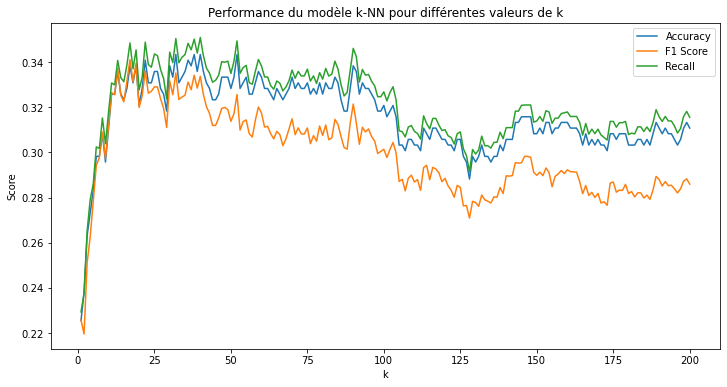

In [67]:
import matplotlib.pyplot as plt

# Création du graphe
plt.figure(figsize=(12, 6))

# Tracer les courbes pour chaque métrique
plt.plot(k_values, accuracies, label='Accuracy')
plt.plot(k_values, f1_scores, label='F1 Score')
plt.plot(k_values, recalls, label='Recall')

# Ajout des légendes et labels
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Performance du modèle k-NN pour différentes valeurs de k')
plt.legend()

# Afficher le graphe
plt.show()

On observe des pics et des creux, ce qui pourrait suggérer que certaines valeurs de k sont idéales pour ce modèle et cet ensemble de données précis. Il est également à noter que l'accuracy et le score F1 semblent évoluer en tandem, alors que le rappel présente un comportement quelque peu distinct, ce qui pourrait suggérer que les modifications de k influencent le rappel de manière différente par rapport aux autres indicateurs.

Le graphe montre que la valeur de k qui maximise les trois métriques est 22.

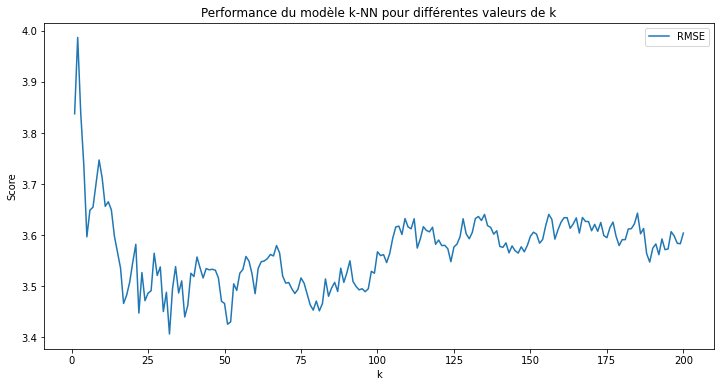

In [69]:
import matplotlib.pyplot as plt

# Création du graphe
plt.figure(figsize=(12, 6))

plt.plot(k_values, rmses, label='RMSE')

# Ajout des légendes et labels
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Performance du modèle k-NN pour différentes valeurs de k')
plt.legend()

# Afficher le graphe
plt.show()

Il semble y avoir une plage de valeurs (entre 35 et 20) pour k où le RMSE est relativement bas et stable. 

### Tuning: KNN + Validation croisée

Nous allons tenter d'améliorer le modèle avec une validation croisée: 

In [85]:
from sklearn.model_selection import KFold

def cross_validate(audio_files, labels, num_folds=5, order=3, k=22):
    kf = KFold(n_splits=num_folds)
    accuracies = []

    for fold, (train_index, test_index) in enumerate(kf.split(audio_files), start=1):
        # Séparer les fichiers audio et les étiquettes en ensembles d'entraînement et de test
        training_files = [audio_files[i] for i in train_index]
        training_labels = [labels[i] for i in train_index]
        test_files = [audio_files[i] for i in test_index]
        test_labels = [labels[i] for i in test_index]

        # Convertir les fichiers audio en séquences LPC
        training_lpc = [calculate_lpc_coefficients(file, order) for file in training_files]
        test_lpc = [calculate_lpc_coefficients(file, order) for file in test_files]

        # Calculer la matrice de distances DTW
        distance_matrix = calculate_dtw_distance_matrix(training_lpc + test_lpc)

        # Classer les données de test et calculer l'exactitude
        test_indices = list(range(len(training_lpc), len(training_lpc) + len(test_lpc)))
        predictions = k_nn_elastique(distance_matrix, training_labels, test_indices, k)
        accuracy = sum(pred == true for pred, true in zip(predictions, test_labels)) / len(test_labels)
        accuracies.append(accuracy)

        print(f"Fold {fold}: Exactitude = {accuracy:.4f}")

    avg_accuracy = np.mean(accuracies)
    print(f"\nExactitude moyenne en validation croisée : {avg_accuracy:.4f}")
    return avg_accuracy

# Exécuter la validation croisée
avg_accuracy = cross_validate(audio_files, labels)

Fold 1: Exactitude = 0.3434
Fold 2: Exactitude = 0.3208
Fold 3: Exactitude = 0.3358
Fold 4: Exactitude = 0.3283
Fold 5: Exactitude = 0.3417

Exactitude moyenne en validation croisée : 0.3340


### Conclusion de la partie 1:

Stabilité du Modèle : La stabilité des scores d'exactitude à travers les différents folds suggère que le modèle n'est pas excessivement sensible aux variations spécifiques des données dans chaque fold. Cela indique une certaine robustesse.

Performance Modérée : Une exactitude d'environ 33% est assez modeste pour un système de classification. Cela peut indiquer que les caractéristiques actuelles (coefficients LPC avec l'ordre choisi) et/ou la méthode de classification (k-NN avec la distance DTW) ne capturent pas entièrement les nuances nécessaires pour une classification plus précise.

## Partie 2 : Développement d’un système de reconnaissance de la parole basé sur les coefficients MFCC et les Modèles de Markov Cachés. 


----------------------------------------------------------------------

La Partie 2 de ce BE consiste à développer un système de reconnaissance de la parole utilisant les coefficients MFCC (Mel-Frequency Cepstral Coefficients) et les Modèles de Markov Cachés (HMM). Voici une description détaillée de chaque étape, y compris le code pour diviser le jeu de données en ensembles d'entraînement et de test :

In [1]:
import librosa
from librosa.feature import mfcc
audio, Fe = librosa.load('digit_dataset/1/1_theo_47.wav') 
mfcc_features = mfcc(y=audio, sr=Fe, n_mfcc=15, win_length=512, 
hop_length=512//2 )

In [2]:
pip install hmmlearn

Note: you may need to restart the kernel to use updated packages.


### Etape 0: Division du jeux de donnée en un ensemble de test-train 

In [64]:
from sklearn.model_selection import train_test_split

def split_dataset_by_class(dataset: dict, test_size: float = 0.3) -> tuple[dict, dict]:
    """
    Divise le dataset en ensembles d'entraînement et de test pour chaque classe.

    :param dataset: Dictionnaire avec des étiquettes de classe comme clés et des listes de fichiers audio comme valeurs.
    :param test_size: Proportion de l'ensemble de données à inclure dans l'ensemble de test.
    :return: Tuple contenant deux dictionnaires - un pour l'ensemble d'entraînement et un pour l'ensemble de test, 
             où chaque clé est une étiquette de classe et chaque valeur est une liste de fichiers audio.
    """
    train_data = {}
    test_data = {}

    for label, files in dataset.items():
        # Diviser les fichiers de cette classe en ensembles d'entraînement et de test
        train_files, test_files = train_test_split(files, test_size=test_size)

        # Stocker les divisions dans les dictionnaires correspondants
        train_data[label] = train_files
        test_data[label] = test_files

    return train_data, test_data

### Étape 1 : Extraction des Coefficients MFCC

In [65]:
import librosa
from librosa.feature import mfcc
import numpy as np

def extract_mfcc(audio_file: str, n_mfcc: int = 15) -> np.ndarray:
    """
    Extrait les coefficients MFCC d'un fichier audio.

    :param audio_file: Chemin du fichier audio à traiter.
    :param n_mfcc: Nombre de coefficients MFCC à extraire.
    :return: Un tableau NumPy des coefficients MFCC extraits, transposé pour avoir une forme constante.
    """
    audio, Fe = librosa.load(audio_file)
    mfcc_features = mfcc(y=audio, sr=Fe, n_mfcc=n_mfcc, win_length=512, hop_length=512//2)
    return mfcc_features.T

### Étape 2 : Préparation des Données pour les HMM

In [67]:
def prepare_data_for_hmm(audio_files: list, n_mfcc: int = 15) -> tuple[np.ndarray, list]:
    """
    Prépare les données MFCC pour l'entraînement des modèles HMM.

    :param audio_files: Liste des chemins de fichiers audio à traiter.
    :param n_mfcc: Nombre de coefficients MFCC à extraire pour chaque fichier audio.
    :return: Tuple contenant une matrice NumPy des coefficients MFCC (X) et une liste des longueurs 
             de séquences MFCC pour chaque fichier audio (lengths).
    """
    X = np.empty((0, n_mfcc))  # Initialiser une matrice vide pour les caractéristiques MFCC
    lengths = []  # Liste pour stocker les longueurs des séquences MFCC

    # Parcourir chaque fichier audio et extraire les caractéristiques MFCC
    for file in audio_files:
        mfcc_features = extract_mfcc(file, n_mfcc)
        X = np.append(X, mfcc_features, axis=0)  # Ajouter les caractéristiques à la matrice X
        lengths.append(len(mfcc_features))  # Ajouter la longueur de la séquence à la liste lengths

    return X, lengths

### Etape 3: Entraînement des modèles HMM

In [68]:
from hmmlearn import hmm

def train_hmm_models(audio_files_by_class: dict) -> dict:
    """
    Entraîne des modèles de Markov Cachés (HMM) pour chaque classe de fichiers audio.

    :param audio_files_by_class: Dictionnaire avec des étiquettes de classe comme clés et des listes de fichiers audio comme valeurs.
    :return: Dictionnaire des modèles HMM entraînés, avec les étiquettes de classe comme clés et les modèles HMM comme valeurs.
    """
    models = {}  # Dictionnaire pour stocker les modèles HMM pour chaque classe

    # Parcourir chaque classe et ses fichiers associés
    for class_label, files in audio_files_by_class.items():
        # Préparer les données MFCC pour les fichiers de cette classe
        X, lengths = prepare_data_for_hmm(files)

        # Créer et entraîner un modèle HMM pour cette classe
        model = hmm.GaussianHMM(n_components=4, n_iter=1000)
        model.fit(X, lengths)

        # Stocker le modèle entraîné dans le dictionnaire
        models[class_label] = model

    return models

### Étape 4 : Reconnaissance et Classification

In [82]:
def classify_audio(models: dict, test_audio_file: str) -> int:
    """
    Classifie un fichier audio en utilisant les modèles HMM entraînés.

    :param models: Dictionnaire des modèles HMM, avec des étiquettes de classe comme clés.
    :param test_audio_file: Chemin du fichier audio à classer.
    :return: L'étiquette de classe prédite pour le fichier audio.
    """
    # Extraire les caractéristiques MFCC du fichier audio
    mfcc_features = extract_mfcc(test_audio_file)

    # Initialiser le score et l'étiquette pour la meilleure prédiction
    best_score, best_label = float('-inf'), None

    # Parcourir chaque modèle HMM et évaluer la probabilité du fichier audio
    for label, model in models.items():
        score = model.score(mfcc_features)
        # Mettre à jour le meilleur score et l'étiquette si nécessaire
        if score > best_score:
            best_score = score
            best_label = label

    # Retourner l'étiquette de classe avec le score le plus élevé
    return best_label

### Étape 5 : Création d'un disctionnaire contenant tout les fichiers audios avec leurs label

Cette fonction vas transformer notre dossier en un dictionnaire avec la clé qui correspont à leur classe.

In [14]:
import os

def create_audio_files_by_class(audio_directory: str) -> dict:
    """
    Crée un dictionnaire des fichiers audio classés par chiffre.

    :param audio_directory: Chemin du répertoire contenant les sous-dossiers de chiffres avec des fichiers audio.
    :return: Dictionnaire avec les chiffres comme clés (0-9) et les listes des chemins de fichiers audio comme valeurs.
    """
    audio_files_by_class = {}  # Dictionnaire pour stocker les fichiers audio par classe

    # Parcourir chaque sous-dossier représentant un chiffre
    for chiffre in range(10):
        class_path = os.path.join(audio_directory, str(chiffre))
        if os.path.isdir(class_path):
            audio_files_by_class[chiffre] = []  # Initialiser la liste pour ce chiffre
            # Ajouter tous les fichiers .wav dans le sous-dossier à la liste
            for filename in os.listdir(class_path):
                if filename.endswith('.wav'):
                    file_path = os.path.join(class_path, filename)
                    audio_files_by_class[chiffre].append(file_path)

    return audio_files_by_class

# Utilisation 
audio_directory = 'digit_dataset'
audio_files_by_class = create_audio_files_by_class(audio_directory) 
# audio_files_by_class = {0: ['0_file1.wav', '0_file2.wav'...], 1: ['1_file1.wav', '1_file2.wav',...] ...} 

### Pre-processing (split dataset)

In [27]:

train_dataset, test_dataset = split_dataset_by_class(audio_files_by_class)
print("Nombre de donnée pour l'entrainement de chaque classe: ",len(train_dataset[0]))
print("Les classes pour l'entrainement: ", train_dataset.keys())
print("Nombre de donnée pour le test de chaque classe: ",len(test_dataset[0]))
print("Les classes pour le test: ", test_dataset.keys())

Nombre de donnée pour l'entrainement de chaque classe:  139
Les classes pour l'entrainement:  dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Nombre de donnée pour le test de chaque classe:  60
Les classes pour le test:  dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


### Entrainement du modèle 

In [28]:
# Entraîner les modèles HMM
models = train_hmm_models(train_dataset)

c:\Users\tariq\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1767
  warnings.warn(


### Evaluation du modèle

Ce script permet de récupérer un fichier test est d'évaluer si la prédiction est correcte ou pas.

In [81]:
import random

# Générer un nombre entier aléatoire entre 0 et 60
random_int_class = random.randint(0, 9)
random_integer = random.randint(0, 60)
# récumérer un fichier test 
test_file = test_dataset[random_int_class][random_integer]
print(test_file)
test_label = classify_audio(models, test_file)
print(test_label)
if random_int_class == test_label: 
    print("Correct prediction (^v^) !")
else:
    print("Incorrect prediction (-_-) !")

digit_dataset\8\8_nicolas_0.wav
8
Correct prediction (^v^) !


Nous allons evaluer notre modèle en utilisant notre jeux de donnée de test et quelques métriques d'évaluations.

In [63]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
import numpy as np

# Fonction pour extraire les caractéristiques MFCC des données de test
def extract_features_for_test(test_data_by_class: dict, n_mfcc: int = 15) -> tuple[list, list]:
    """
    Extrait les caractéristiques MFCC des données de test.

    :param test_data_by_class: Dictionnaire avec des étiquettes de classe comme clés et des listes de fichiers audio comme valeurs.
    :param n_mfcc: Nombre de coefficients MFCC à extraire.
    :return: Tuple contenant deux listes - une pour les caractéristiques MFCC et une pour les vraies étiquettes.
    """
    features = []  # Liste pour stocker les caractéristiques MFCC
    true_labels = []  # Liste pour stocker les vraies étiquettes

    # Parcourir chaque classe et ses fichiers associés
    for label, files in test_data_by_class.items():
        for file in files:
            mfcc_features = extract_mfcc(file, n_mfcc)  # Extraire les caractéristiques MFCC
            features.append(mfcc_features)  # Ajouter les caractéristiques à la liste
            true_labels.append(label)  # Ajouter l'étiquette correspondante à la liste
    return features, true_labels

# Fonction pour évaluer le modèle
def evaluate_model(models: dict, test_features: list, true_labels: list) -> tuple[float, float, float]:
    """
    Évalue le modèle en utilisant les caractéristiques MFCC des données de test.

    :param models: Dictionnaire des modèles HMM entraînés.
    :param test_features: Liste des caractéristiques MFCC pour les données de test.
    :param true_labels: Liste des vraies étiquettes pour les données de test.
    :return: Tuple contenant l'exactitude, le rappel et le score F1.
    """
    predicted_labels = []  # Liste pour stocker les étiquettes prédites

    # Parcourir les caractéristiques MFCC des données de test
    for mfcc_features in test_features:
        best_score, best_label = float('-inf'), None  # Initialiser le meilleur score et l'étiquette
        # Parcourir chaque modèle et calculer son score pour les caractéristiques actuelles
        for class_label, model in models.items():
            score = model.score(mfcc_features)
            # Mettre à jour le meilleur score et l'étiquette si nécessaire
            if score > best_score:
                best_score = score
                best_label = class_label
        predicted_labels.append(best_label)  # Ajouter l'étiquette prédite à la liste

    # Calculer les métriques d'évaluation
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    return accuracy, recall, f1

# Extraire les caractéristiques MFCC pour les données de test
test_features, true_labels = extract_features_for_test(test_dataset)

# Évaluer le modèle avec les données de test
accuracy, recall, f1 = evaluate_model(models, test_features, true_labels)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


c:\Users\tariq\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1321
  warnings.warn(


Accuracy: 0.6833333333333333
Recall: 0.6833333333333333
F1 Score: 0.6874384511641407


- Rappel (Recall) : 0,6833 (68,33 %) - Le rappel est également de 68,33 %, ce qui indique que le modèle est capable d'identifier correctement 68,33 % de toutes les instances positives à travers les classes.
- Exactitude (Accuracy) : 0,6833 (68,33 %) - Cela signifie que 68,33 % des prédictions du modèle étaient correctes. En d'autres termes, le modèle a correctement identifié la classe des fichiers audio plus des deux tiers du temps, ce qui est une performance raisonnablement bonne.
- Score F1 : 0,6874 (68,74 %) - Le score F1, qui équilibre la précision et le rappel, est de 68,74 %. C'est un bon indicateur que le modèle a une performance équilibrée en termes de précision et de rappel.